## Setup

In [ ]:
!pip install segmentation-models-pytorch
!pip install lime
# !git clone https://github.com/marcotcr/lime.git
!pip install gradcam
!pip install shap
!pip install transformers
!pip install grad-cam
!pip install grad-cam
!pip install timm

In [3]:
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.utils import save_image
import torchvision.models as tvmodels
from torchvision import datasets, transforms
import pytorch_grad_cam
import timm


import segmentation_models_pytorch as smp

import numpy as np
import random

import matplotlib.pyplot as plt

sys.path.insert(0, "/content/exlib/src")
import exlib
from exlib.explainers import *
from exlib.explainers.common import *
from exlib.modules import *

In [4]:
import os
import urllib
import tarfile
import shutil
from collections import defaultdict

def download_url(url, root=".", filename=None):
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
    """

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    try:
        print('Downloading ' + url + ' to ' + fpath)
        urllib.request.urlretrieve(url, fpath)
    except (urllib.error.URLError, IOError) as e:
        if url[:5] == 'https':
            url = url.replace('https:', 'http:')
            print('Failed download. Trying https -> http instead.'
                    ' Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(url, fpath)

def balance_dataset(x,y):
    x_new = []
    y_new = []

    path_label_pairs = defaultdict(list)

    for item in zip(x,y):
        path_label_pairs[item[1]].append(item[0])

    min_count = min([len(path_label_pairs[key]) for key in path_label_pairs])
    for key in path_label_pairs:
        reduced_sample = random.sample(path_label_pairs[key],min_count)
        x_new.extend(reduced_sample)
        y_new.extend([key]*min_count)


    return x_new,y_new

def balance_image_directory(parent_directory):
    paths = []
    labels = []

    for label in os.listdir(parent_directory):
        for image in os.listdir(parent_directory+label):
            paths.append(parent_directory+label+'/'+image)
            labels.append(label)

    balanced_paths, balanced_labels = balance_dataset(paths, labels)
    balanced_paths = set(balanced_paths) #converting to set so that lookup time is O(1)
    for path in paths:
        if path not in balanced_paths:
            os.remove(path)


def extract_tarfile(tarfile_name,extracted_folder_name="."):
    file_obj = tarfile.open(tarfile_name,"r")

    file = file_obj.extractall(extracted_folder_name)
    file_obj.close()

def imagenette_full_setup(train_dir='/content/imagenette2-320/train/',test_dir='/content/imagenette2-320/val/',n_examples = None,train_augmentation=None,test_augmentation=None,**kwargs):
        print("test_augmentation",test_augmentation)
        id_class_dict = {0:"tench",217:"english springer",482:"cassette player",491:"chain saw",497:"church",566:"French horn",569:"garbage truck",571:"gas pump",571:"golf ball",701:"parachute"}
        label_class_dict = {"tench":"n01440764","english springer":"n02102040","cassette player":"n02979186","chain saw":"n03000684"}
        selected_labels = list(label_class_dict.values())[:4]

        if not os.path.isdir(train_dir): #Check if a more robust check exists for checking if data has been downloaded(this just checks if folder exists)
            print(f"No dataset found at {train_dir}, proceeding to download")
            download_url("https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz")
            extract_tarfile("imagenette2-320.tgz")

            for label in os.listdir(train_dir):
                if label not in selected_labels:
                    shutil.rmtree(train_dir+label)


            for label in os.listdir(test_dir):
                if label not in selected_labels:
                        shutil.rmtree(test_dir+label)

            balance_image_directory(train_dir)
            balance_image_directory(test_dir)

        else:
            print("Existing Downloaded imagenette dataset found, proceeding with Data Processing")

        train_transforms_list = [
                transforms.RandomRotation(7),
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
        ]

        if train_augmentation == "PatchCutout":
            removal_fraction = kwargs.get('removal_fraction')
            if removal_fraction is None:
                removal_fraction = 0.5

            patch_size = kwargs.get('patch_size')
            if patch_size is None:
                patch_size = 56

            random_removal_fraction = kwargs.get('random_removal_fraction')
            if random_removal_fraction is None:
               random_removal_fraction = False

            random_dist = kwargs.get('random_dist')
            if random_dist is None:
                random_dist = 'binomial'

            train_transforms_list.append(PatchCutout(patch_height=patch_size,patch_width=patch_size,removal_fraction = removal_fraction,random_removal_fraction=random_removal_fraction,random_dist = random_dist))

        elif train_augmentation == "Cutout":
            train_transforms_list.append(Cutout(n_holes = 5, length = 32))

        train_transform = transforms.Compose(train_transforms_list)


        test_transforms_list = [
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ]

        if test_augmentation == "PatchCutout":
            removal_fraction = kwargs.get('removal_fraction')

            if removal_fraction is None:
                removal_fraction = 0.5

            patch_size = kwargs.get('patch_size')
            if patch_size is None:
                patch_size = 56

            random_removal_fraction = kwargs.get('random_removal_fraction')
            if random_removal_fraction is None:
               random_removal_fraction = False

            random_dist = kwargs.get('random_dist')
            if random_dist is None:
                random_dist = 'binomial'

            test_transforms_list.append(PatchCutout(patch_height=patch_size,patch_width=patch_size,removal_fraction = removal_fraction,random_removal_fraction= random_removal_fraction,random_dist = random_dist))

        elif test_augmentation == "Cutout":
            test_transforms_list.append(Cutout(n_holes = 5, length = 32))
        test_transform = transforms.Compose(test_transforms_list)


        train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
        test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)




        return train_dataset,test_dataset


##Kernel SHAP code

In [5]:
import shap
def patch_segment(image, patch_height=8, patch_width=8,permute = None,dtype = "torch"):
    #Input: C,H,W
    if permute is not None:
        image = np.transpose(image,permute)

    channels, image_height, image_width = image.shape
    if image_height % patch_height != 0 or image_width % patch_width != 0:
        print("patch height and width need to perfectly divide image")
        raise ValueError

    row_indices = torch.arange(image_height)
    column_indices = torch.arange(image_width)

    row_factors = row_indices // patch_height
    column_factors = column_indices // patch_width

    row_factor_matrix = row_factors[:, None]
    column_factor_matrix = column_factors[None, :]

    segment = column_factor_matrix * (image_height // patch_height) + row_factor_matrix

    if dtype == "torch":
        return segment.int()
    elif dtype == "numpy":
        return segment.numpy()
    else:
        raise ValueError


def fill_segmentation(values, segmentation,dtype = "torch"):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    if dtype == "numpy":
        return out

    else:
        return torch.Tensor(out)

def mask_image_torch(zs, segmentation, image, model,background=None):
    permuted = False
    if image.shape[0] == 3:
        image = torch.permute(image,(1,2,0))
        permuted = True

    if background is None:
        background = image.mean((0,1))
    out = torch.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2])).to(next(model.parameters()).device)
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background

    if permuted:
        out = torch.permute(out,(0,3,1,2))


    return out

def f_torch(z,image,segments,model):
    x = mask_image_torch(z,segments,image,model,0) #setting background = 0 (black)
    x =  model(x).detach().cpu().numpy()
    return x


def explain_image_cls_with_kernelShap(model, x, ts,
                                kernelShapImageExplainerKwargs={},
                                # Gets FA for every label if top_labels == None
                                explain_instance_kwargs={},
                                get_image_and_mask_kwargs={}):
    """

    """
    segmentation_fn = explain_instance_kwargs.get('segmentation_fn')

    if segmentation_fn is None:
        segments = patch_segment(x,patch_height=56,patch_width=56,dtype="torch") #hard coding patch_height and width for now

    else:
        segments = segmentation_fn(x) #Look into providing arguments to this

    f = lambda z : f_torch(z,x,segments,model)

    ## Images here are not batched
    C, H, W = x.shape
    x_np = x.cpu().permute(1,2,0).numpy()

    explainer = shap.KernelExplainer(f, np.zeros((1,16)))
    shap_values = explainer.shap_values(np.ones((1,16)),nsamples=100)

    if isinstance(ts, torch.Tensor):
        todo_labels = ts.numpy()
    else:
        todo_labels = ts




    for t in todo_labels:
        m = fill_segmentation(shap_values[t][0], segments)
        break #KernelShapImage class only calls this function with single t, so this break should be enough

    return FeatureAttrOutput(m, explainer)



class KernelShapImageCls(FeatureAttrMethod):
    def __init__(self, model,
                 KernelShapImageExplainerKwargs={},
                 explain_instance_kwargs={
                 },
                 get_image_and_mask_kwargs={}):
        super(KernelShapImageCls, self).__init__(model)
        self.KernelShapImageExplainerKwargs = KernelShapImageExplainerKwargs
        self.explain_instance_kwargs = explain_instance_kwargs
        self.get_image_and_mask_kwargs = get_image_and_mask_kwargs

    def forward(self, x, t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t)

        N = x.size(0)
        assert x.ndim == 4 and t.ndim == 1 and len(t) == N

        attrs, kshap_exps = [], []
        for i in range(N):
            xi, ti = x[i], t[i].cpu().item()
            out = explain_image_cls_with_kernelShap(self.model, xi, [ti],
                    kernelShapImageExplainerKwargs=self.KernelShapImageExplainerKwargs,
                    explain_instance_kwargs=self.explain_instance_kwargs,
                    get_image_and_mask_kwargs=self.get_image_and_mask_kwargs)

            attrs.append(out.attributions.unsqueeze(0))
            kshap_exps.append(out.explainer_output)

        return FeatureAttrOutput(torch.cat(attrs, dim=0), kshap_exps)

##Kernel SHAP execution

In [6]:
class ViTModel(nn.Module):
    def __init__(self, num_classes, model_path, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=False,num_classes = 4)
        self.model.load_state_dict(torch.load(model_path))


    def forward(self, x):
        pred = self.model(x)
        return pred

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == "cpu":
    raise Exception("This code will not work without a gpu. Please ensure a gpu is available or use Google Colab with a GPU")


!gdown 1-_XCxamNtahihIJ3fTeCk8urP_udKOnj
model = timm.create_model('vit_base_patch16_224',pretrained=False,num_classes = 4).to(device)


model.load_state_dict(torch.load('/content/vit_timm_vanilla_imagenette_10e_100pt0tr99pt9te.pth'))

vit_model = model

cls_model = ViTModel(in_channels=3, num_classes=4,model_path = "/content/vit_timm_vanilla_imagenette_10e_100pt0tr99pt9te.pth").to(device) #returns classification prediction
cls_model.eval()

In [8]:
_,test_dataset = imagenette_full_setup()
x = test_dataset[7][0]
X = torch.stack([x,x,x]).to(device)
y_cls = cls_model(X)

test_augmentation None
No dataset found at /content/imagenette2-320/train/, proceeding to download


In [9]:
import shap
kshap_cls = KernelShapImageCls(cls_model)
kshap_cls_exp = kshap_cls(X, t=[0,1,2])
kshap_cls_attrs = kshap_cls_exp.attributions

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Visualization

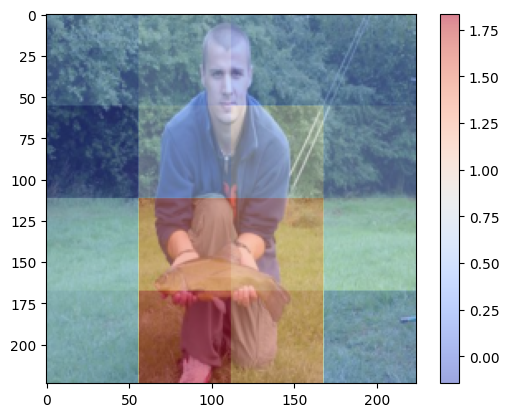

In [10]:
plt.imshow(torch.permute(X[0].cpu(),(1,2,0)))
plt.imshow(kshap_cls_attrs[0].squeeze(),cmap='coolwarm', alpha=0.5)
plt.colorbar()